In [1]:
# pip install pyhealth

In [51]:
import sys
sys.path.insert(0, "/shared/chaoqiy2/github/PyHealth")

In [52]:
import torch
import numpy as np

device = torch.device("cuda:1")

### STEP 1: load the chest Xray data

In [53]:
from pyhealth.datasets import COVID19CXRDataset

root = "/shared/chaoqiy2/data/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root, refresh_cache=False)

base_dataset.stat()

Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


### STEP 2: set task and processing the data

In [54]:
from torchvision import transforms

sample_dataset = base_dataset.set_task()

imsize = 64

# the transformation automatically normalize the pixel intensity into [0, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1)), # only use the first channel
    transforms.Resize((imsize, imsize)),
])

def encode(sample):
    sample["path"] = transform(sample["path"])
    return sample

sample_dataset.set_transform(encode)

Generating samples for COVID19CXRClassification: 100%|████| 21165/21165 [00:00<00:00, 1644634.64it/s]


In [55]:
from pyhealth.datasets import split_by_visit, get_dataloader

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.8, 0.1, 0.1]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False, num_workers=10)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False, num_workers=10)

In [56]:
data = next(iter(train_dataloader))
print (data["path"][0].shape)

print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

torch.Size([3, 64, 64])
loader size: train/val/test 16932 2116 2117


### STEP3: define the diffusion model

In [45]:
from pyhealth.models import Diffuser

diff_steps = 25
n_labels = 4 # covid, lung opacity, normal, pneumonia
sigma = 0.2

model = Diffuser(
    input_channel = 3,
    input_size = imsize,
    hidden_dim = 128,
    diff_steps = diff_steps,
    n_labels = n_labels,
    sigma = sigma,
)
model.to(device)

print ()

In [46]:
# normal distribution sampler (we could throw to cuda for once)
unit_normal = torch.distributions.Normal(0, sigma)
unit_normal.loc = unit_normal.loc.to(device)
unit_normal.scale = unit_normal.scale.to(device)

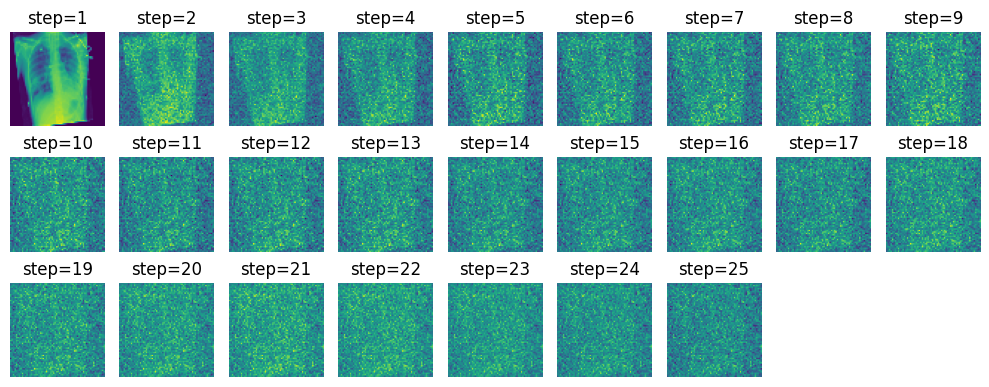

In [47]:
# demo: diffusion process
batch = next(iter(train_dataloader))
image = batch["path"][0]
label = batch["label"][0]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

for i in range(diff_steps):
    plt.subplot(3, 9, i + 1)
    
    # we only show the first color channel by index=0
    plt.imshow(image[0])
    plt.axis('off')
    plt.title(f"step={i+1}")
    
    # Draw noise from a normal distribution
    noise = unit_normal.sample(image.shape).cpu()
    # Add the noise to the image
    image += noise
    
plt.tight_layout()

### STEP 4 & 5: training the Diffusion model with the evaluation function

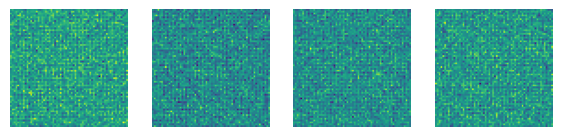

In [48]:
def evaluate(model, diffusion_steps):
    
    # 0, 1, 2, 3
    labels = torch.arange(4)
    
    # random images
    noisy_images = unit_normal.sample((len(labels), 3, imsize, imsize)) * np.sqrt(diff_steps)
    
    plt.figure(figsize=(7, 3))
    
    # we run diffusion process for multiple steps
    # to denoise the noisy images into a digit image
    for diff_step in range(diff_steps):    
        step = diff_steps - diff_step - 1
        with torch.no_grad():
            noise = model(noisy_images, step, labels)
        noisy_images -= noise

    for i in range(4):
        plt.subplot(1, 4, i+1)
        # print the digit one by one, only show the first channel
        plt.imshow(noisy_images[i].cpu()[0])
        plt.axis('off')
    plt.show()

evaluate(model, diff_steps)

100%|████████████████████████████████████████████████████████████████| 67/67 [00:28<00:00,  2.34it/s]


Epoch: 0 	 Loss: 133.69132697582245


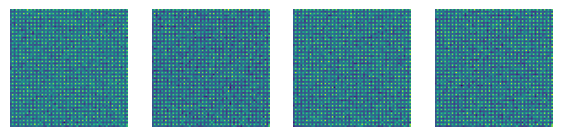

100%|████████████████████████████████████████████████████████████████| 67/67 [00:29<00:00,  2.31it/s]


Epoch: 1 	 Loss: 133.69425992667675


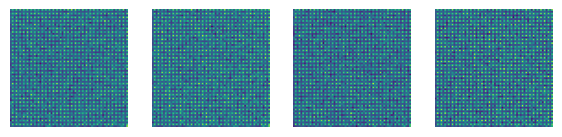

100%|████████████████████████████████████████████████████████████████| 67/67 [00:28<00:00,  2.33it/s]


Epoch: 2 	 Loss: 133.69522004574537


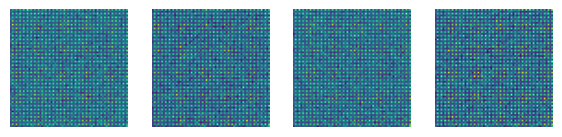

100%|████████████████████████████████████████████████████████████████| 67/67 [00:28<00:00,  2.37it/s]


Epoch: 3 	 Loss: 133.69811917841434


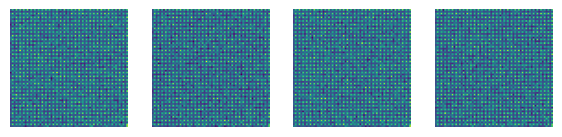

100%|████████████████████████████████████████████████████████████████| 67/67 [00:28<00:00,  2.34it/s]


Epoch: 4 	 Loss: 133.69269440323114


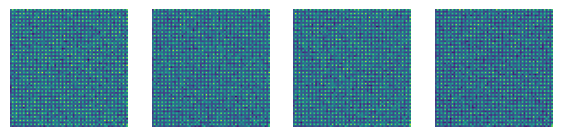

100%|████████████████████████████████████████████████████████████████| 67/67 [00:28<00:00,  2.35it/s]


Epoch: 5 	 Loss: 133.691550090909


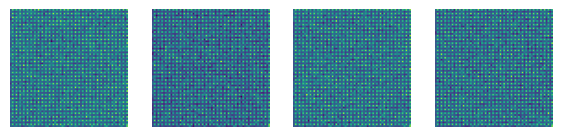

100%|████████████████████████████████████████████████████████████████| 67/67 [00:28<00:00,  2.32it/s]


Epoch: 6 	 Loss: 133.68834939599037


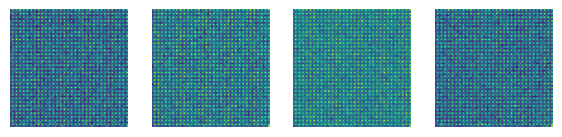

100%|████████████████████████████████████████████████████████████████| 67/67 [00:25<00:00,  2.68it/s]


Epoch: 7 	 Loss: 133.69459226727486


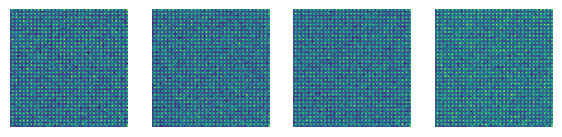

100%|████████████████████████████████████████████████████████████████| 67/67 [00:23<00:00,  2.85it/s]


Epoch: 8 	 Loss: 133.69285207986832


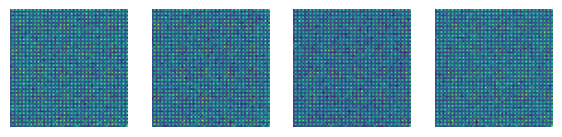

100%|████████████████████████████████████████████████████████████████| 67/67 [00:22<00:00,  2.91it/s]


Epoch: 9 	 Loss: 133.68926513195038


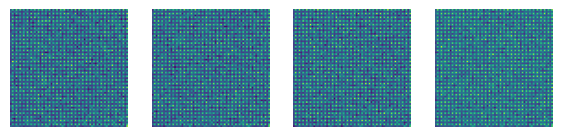

In [49]:
import torch.nn as nn
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), 0.1)
criterion = nn.MSELoss()
label_map = {"COVID": 0, "Lung Opacity": 1, "Normal": 2, "Viral Pneumonia": 3}

for epoch in range(10):
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        images = torch.stack(batch["path"]).to(device)
        labels = torch.LongTensor([label_map[item] for item in batch["label"]])

        for step in torch.randperm(diff_steps):
            # get a sample at step: original image + sqrt(step) * normal sample
            less_noisy = images + unit_normal.sample(images.shape) * np.sqrt(step)
            # get a normal sample
            one_step_noise = unit_normal.sample(images.shape)
            # get the sample at (step + 1)
            more_noisy = less_noisy + one_step_noise 
        
            output = model(more_noisy, step, labels)
            loss = criterion(output, one_step_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

            epoch_loss += loss.item()
    print(f'Epoch: {epoch} \t Loss: {epoch_loss}')
    
    evaluate(model, diff_steps)

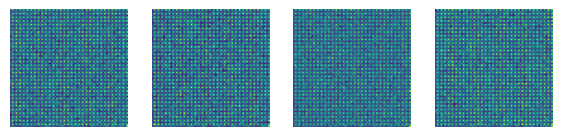

In [50]:
evaluate(model, diff_steps)